# Main Notebook for Dutch Dyslexia Programme (DDP)

1. [Loading EEG-data and metadata](#1)
2. [ePodium Events](#2)
3. [The Experiment](#3)
4. [Processing](#4)
5. [Analysing event related potentials](#5)

#### Import Packages

In [1]:
import mne
import numpy as np
import pandas as pd
import os
import glob
import ipywidgets
import wave # For analyzing .wav audio files

from functions import data
from functions import processing
from functions import display_helper

from functions.ddp import DDP
ddp = DDP()

import local_paths

<br>

<a id='1'></a>
## 1. Loading data

#### Load paths to EEG files
Make sure *local_paths.DDP_dataset* contains the path to the __dataset__

In [2]:
experiments_raw, experiments_id = data.load_raw_dataset(local_paths.DDP_dataset, 
                                                       file_extension='.cnt', 
                                                       preload=False,
                                                       max_files=50)


/home/fpauwels/eegyolk/floris_files/functions/data.py:23: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(path, preload=preload)


50 EEG files loaded


/home/fpauwels/eegyolk/floris_files/functions/data.py:23: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(path, preload=preload)


#### Create labels from raw .cnt files.
    file / personal_code / age group / age_days

In [3]:
path_label_csv = os.path.join(local_paths.DDP, "labels_raw.csv")
ages_directory = os.path.join(local_paths.DDP_metadata, "ages")
labels_raw = ddp.create_labels_raw(path_label_csv, local_paths.DDP_dataset, ages_directory)

#### Participants Info

In [4]:
min_age, max_age = labels_raw["age_days"].min(), labels_raw["age_days"].max()
print(f"The participants are between the age of {min_age} "
      f"and {int(max_age)} days. "
      f"({round(min_age/30, 1)} to "
      f"{round(max_age/30,1)} months)")

The participants are between the age of 321.0 and 1422 days. (10.7 to 47.4 months)


In [17]:
experiments=sorted(labels_raw["file"].values)

#### Choose file with widget:

In [18]:
def f(file):
    return file

participant_widget = ipywidgets.interactive(f, file=sorted(labels_raw["file"].values))
display(participant_widget)

interactive(children=(Dropdown(description='file', options=('001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk.cnt…

<br>

<a id='2'></a>
## 2. DDP Events

The DDP experiment is an *auditory oddball experiment*. Children listen to a sequence that contains standard and deviant syllables in order to elicit the *mismatch response*. 
   
For measurement 30 electrodes are used. The measurement frequency is 500 Hz. 
    
Each test is around __30 minutes__, with sequences of around 7.5 minutes containing four different conditions. Ideally, each condition has 400 standards /b/ak (events: 2, 3, 4, 5), 50 deviants /d/ak (events: 55, 66, 77, 88), and 50 first standards (events: 12, 13, 14, 15)



### Load events

In [ ]:
## Store events in local path
n_events_stored = len(glob.glob(os.path.join(local_paths.ePod_events, '*.txt')))
if n_events_stored != len(experiments_raw):
    data.save_events(local_paths.ePod_events, experiments_raw, experiments_id)

## Load events
events = data.load_events(local_paths.ePod_events, experiments_id)

## Set multiple pronounciations as same event id to reduce the unique events from 78 to 12.
events_12 = epodium.group_events_12(events)

160_05_jr_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_mixed
Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']


/tmp/ipykernel_420903/3304700916.py:6: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events, event_id = event_dict)


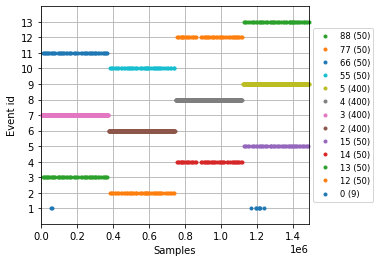

In [6]:
index = 10

print(experiments_id[index])

events, event_dict = mne.events_from_annotations(experiments_raw[index])
fig = mne.viz.plot_events(events, event_id = event_dict)

## Processing

In [7]:
raw_paths = sorted(glob.glob(os.path.join(local_paths.DDP_dataset, '**/*' + ddp.file_extension)))
# for raw_path in raw_paths:
#     processing.process_raw(raw_path, epodium, local_paths.ePod_processed)

## Multiprocessing:
processing.process_raw_multiprocess(raw_paths, ddp, local_paths.DDP_processed)

NameError: name 'raw_path' is not defined

Using matplotlib as 2D backend.
Opening raw-browser...


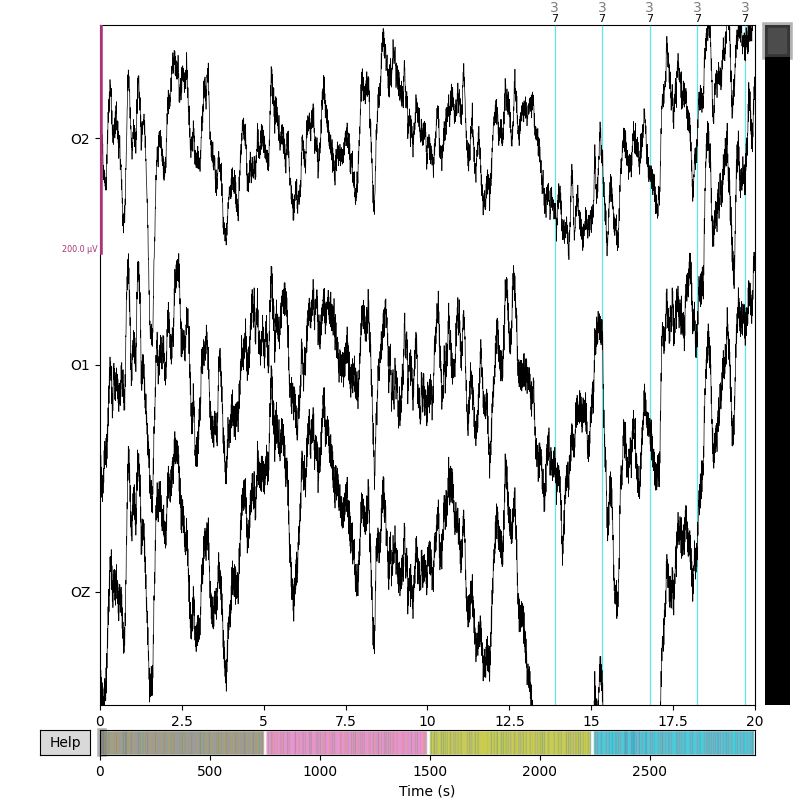

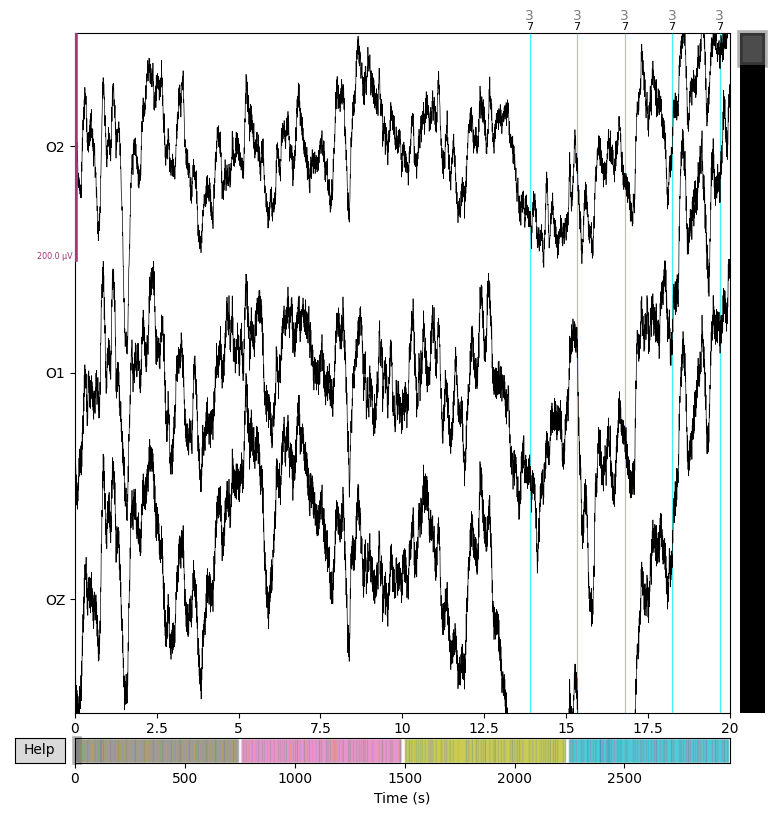

In [20]:
%matplotlib widget

#events = ddp.get_events_from_raw(experiments_raw[index])

mne.viz.plot_raw(experiments_raw[index], events, n_channels = 3, 
                       scalings = 100e-6, duration = 20, start = 0)

<br>

<a id='3'></a>
## 3. The Experiment

#### Choose which participant to analyse

#### Show part of the EEG signal
When a new experiment is chosen, this cell needs to be run again to visualise its EEG data.

In [ ]:
## Makes the plot interactive, comment out if not working:
# %matplotlib widget 

participant_raw = experiments_raw[experiments_id.index(participant_widget.result)]
participant_events = events_12[experiments_id.index(participant_widget.result)]

fig = mne.viz.plot_raw(participant_raw, participant_events, n_channels = 3, 
                       scalings = 50e-6, duration = 0.5, start = 1000)

#### Plot events across time

The events are grouped into __12 event types__, 3 for each condition. 

Ideally, each condition has __120 deviants__ (D) and __360 standards__ (S).

The test also contains __first standards__ (FS) to make the child accustomed to the standard. First standards are discarded when calculating the mismatch response. 

In [ ]:
fig = mne.viz.plot_events(participant_events, event_id=epodium.event_dictionary, 
                          color=display_helper.color_dictionary, sfreq=epodium.frequency)

<br>

<a id='4'></a>
## 4. Processing
#### Filtering ePodium dataset and rejecting bad trials

The EEG data located in _local_paths.ePod_dataset_ is cleaned with the following techniques:
+ A high-pass filter on the raw EEG sequence with cutoff frequency 0.1 Hz to remove slow trends
+ Splitting the raw data into 1 second epochs in which the event occurs at 0.2s.
+ The epochs are cleaned with the autoreject library. This library contains classes that automatically reject bad trials and repair bad sensors in EEG data. The AutoReject and Ransac classes are used. https://autoreject.github.io/stable/index.html
+ A low-pass filter on the epochs 

The function process_raw splits the raw files up into epochs and saves the events externally. It takes a while to process each file, mainly due to the complexity of the autoreject method. To save some time, multiple raw files are processed simultaniously via multiprocessing.

In [ ]:
raw_paths = sorted(glob.glob(os.path.join(local_paths.ePod_dataset, '*' + epodium.file_extension)))

# for raw_path in raw_paths:
#     processing.process_raw(raw_path, epodium, local_paths.ePod_processed)

## Multiprocessing:
processing.process_raw_multiprocess(raw_paths, epodium, local_paths.ePod_processed)

#### Extract valid experiments
Processed files with too few standards and deviants are considered invalid.

In [ ]:
directory_events = os.path.join(local_paths.ePod_processed, "events")
valid_experiments = processing.valid_experiments(directory_events,
                                                 min_standards = 180, 
                                                 min_deviants = 80)

<br>

<a id='5'></a>
## 5. Analysing event related potentials (ERPs)

   The voltage change in the brain as a response to an event is called the *event-related potential* (ERP)
    The response difference between a standard and deviant ERP is called the *mismatch response* (MMR).
    The mismatch response can be analysed to predict differences between participants.


#### Choose experiment to analyse

In [ ]:
def load_participant_data(experiment):
    global epochs
    epochs = mne.read_epochs(os.path.join(local_paths.ePod_processed, experiment + "_epo.fif"), verbose = 0)
    print(f"Loaded experiment: {experiment} ")

ipywidgets.interact(load_participant_data, experiment=valid_experiments);

#### Widget for plotting standard, deviant, and mismatch ERPs

In [ ]:
condition = ipywidgets.RadioButtons(options=epodium.conditions, 
                                    description='Condition:',
                                    value="GiepM")
event_type = ipywidgets.RadioButtons(options=["standard", "deviant", "MMN"], 
                                     description='Event type:', 
                                     value="standard")

def plot_ERP_widget(con, ev):
    display_helper.plot_ERP(epochs, con, ev)

ui = ipywidgets.HBox([condition, event_type])
out = ipywidgets.interactive_output(plot_ERP_widget, {'con': condition, 'ev': event_type})
display(ui, out)